In [1]:
import pandas as pd
import gym_trading
import gym
import sys
import itertools
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

import baselines.common.tf_util as U

from baselines import deepq
from baselines.deepq.replay_buffer import ReplayBuffer
from baselines.common.schedules import LinearSchedule

# Trading Framework

This framework is developed based on Peter Henry https://github.com/Henry-bee/gym_trading/ which in turn on developed of Tito Ingargiola's https://github.com/hackthemarket/gym-trading. 


First, define the address for the CSV data


In [2]:
csv = "data/EURUSD60.csv"

# Create a new OpenAI Gym environment with the customised Trading environment



 .initialise_simulator() must be invoked after **env.make('trading-v0')** . Within this function, provide these arguments:


* **csv_name**: Address of the data


* **trade_period**: (int), Max of duration of each trades. *Default: 1000*


* **train_split**: (float), Percentage of data set for training. *Default: 0.7*

In [3]:
csv = "/home/adrian/Escritorio/polinex/EURUSD60.csv"

env = gym.make('trading-v0')
env.initialise_simulator(csv, trade_period=50, train_split=0.7)

[2017-07-09 18:39:23,128] Making new env: trading-v0


                       Return       ATR  Open Trade  Duration Trade
Date_Time                                                          
2013-12-02 02:00:00  0.421251  0.355142         0.0             0.0


/home/adrian/.local/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


# States map

states_map is a discretized observation space bounded by the extreme values of features with an interval of 0.5. Also I use trade duration and boolean of active trade. This observations are dinamical, while the algorithm runs. 

In [4]:
env.sim.states

array([[ 0.42125144,  0.35514246,  0.        ,  0.        ],
       [ 1.7094119 ,  0.45689009,  0.        ,  0.        ],
       [-0.59190109,  0.45925152,  0.        ,  0.        ],
       ..., 
       [-1.00049976, -0.45976391,  0.        ,  0.        ],
       [-0.20124835, -0.51999441,  0.        ,  0.        ],
       [ 0.31455146, -0.61636501,  0.        ,  0.        ]])

# The magic (Deep Q-Network)

The point of Baselines OpenAI is set of high-quality implementations of reinforcement learning algorithms. A lot of projects for reinforcement trading uses their own implementations, causing small bugs or hard to maintenance/improvement.

There are a lot of good resources to drill down on this topic. 
But well above, the core of Q_learning and DQNs can express with the next diagrams

![Image of DQN](https://raw.githubusercontent.com/udacity/deep-learning/master/reinforcement/assets/deep-q-learning.png)


![Image of Q-Network](https://raw.githubusercontent.com/udacity/deep-learning/master/reinforcement/assets/q-network.png)


### Learning resources:

http://karpathy.github.io/2016/05/31/rl/

http://minpy.readthedocs.io/en/latest/tutorial/rl_policy_gradient_tutorial/rl_policy_gradient.html

http://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html

http://kvfrans.com/simple-algoritms-for-solving-cartpole/

https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-1-fd544fab149

https://dataorigami.net/blogs/napkin-folding/79031811-multi-armed-bandits


## Set the model 

So, let's get our hands dirty. First set our network

In [5]:
def model(inpt, num_actions, scope, reuse=False):
    """This model takes as input an observation and returns values of all actions."""
    with tf.variable_scope(scope, reuse=reuse):
        out = inpt
        out = layers.fully_connected(out, num_outputs=128, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=64, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=32, activation_fn=tf.nn.tanh)
        out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)
        return out

And define run_test function to use in the end of every episode

In [6]:
def run_test(env, act, episodes=1, final_test=False):
    obs = env._reset(train=False)
    start = env.sim.train_end_index + 1
    end = env.sim.count - 2

    for episode in range(episodes):
        done = False
        while done is False:
            action = act(obs[None])
            obs, reward, done, info = env.step(action)

        if not final_test:
            journal = pd.DataFrame(env.portfolio.journal)
            profit = journal["Profit"].sum()
            return env.portfolio.average_profit_per_trade, profit
        else:
            print("Training period  %s - %s" % (env.sim.date_time[start], env.sim.date_time[end]))
            print("Average Reward is %s" % (env.portfolio.average_profit_per_trade))

    if final_test:
        env._generate_summary_stats()


## Running the enviroment!

At this point, we can start up the enviroment and run the episodes. The most important is:

* Set the `episode_rewards` with the reward that we want. For example if we want maximice each trade: `episode_rewards[-1] += rew`
* Set the solved function. The training will stop when the outcome of function get True. For example: `is_solved = np.mean(episode_rewards[-101:-1]) > 1000 or t == 100000`
* Instanciate `deepq.build_train`. That is the core of Baseline of OpenAI.

### `build_train` Creates the train function:

#### Parameters

* make_obs_ph: str -> tf.placeholder or TfInput -> a function that takes a name and creates a placeholder of input with that name

* q_func: (tf.Variable, int, str, bool) -> tf.Variable -> the model that takes the following inputs:
    * observation_in: object -> the output of observation placeholder
    * num_actions: int -> number of actions
    * scope: str
    * reuse: bool -> should be passed to outer variable scope and returns a tensor of shape (batch_size, num_actions) with values of every action.

* num_actions: int -> number of actions

* reuse: bool -> whether or not to reuse the graph variables

* optimizer: tf.train.Optimizer -> optimizer to use for the Q-learning objective.

* grad_norm_clipping: float or None -> clip gradient norms to this value. If None no clipping is performed.

* gamma: float -> discount rate.

* double_q: bool -> if true will use Double Q Learning (https://arxiv.org/abs/1509.06461).In general it is a good idea to keep it enabled.

* scope: str or VariableScope -> optional scope for variable_scope.

* reuse: bool or None -> whether or not the variables should be reused. To be able to reuse the scope must be given.

#### Returns

* act: (tf.Variable, bool, float) -> tf.Variable -> function to select and action given observation.

* train: (object, np.array, np.array, object, np.array, np.array) -> np.array  -> optimize the error in Bellman's equation.See the top of the file for details.

* update_target: () -> () -> copy the parameters from optimized Q function to the target Q function.
debug: {str: function} -> a bunch of functions to print debug data like q_values.



[2017-07-09 18:39:23,452] VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.


[2017-07-09 18:39:23,474] VARIABLES collection name is deprecated, please use GLOBAL_VARIABLES instead; VARIABLES will be removed after 2017-03-02.
/home/adrian/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/adrian/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-------------------------------------
steps                     | 2138
episodes                  | 1
% time spent exploring    | 79
--
mean episode reward       | nan
Total operations          | 391
Avg duration trades       | 3.07
Total profit              | -960.0
Avg profit per trade      | -2.872
--
Total profit test:        > -229.6
Avg profit per trade test > -2.031
-------------------------------------
-------------------------------------
steps                     | 4277
episodes                  | 2
% time spent exploring    | 58
--
mean episode reward       | -4001.2
Total operations          | 430
Avg duration trades       | 2.02
Total profit              | -1238.0
Avg profit per trade      | -2.16
--
Total profit test:        > -313.4
Avg profit per trade test > -2.581
-------------------------------------
-------------------------------------
steps                     | 6416
episodes                  | 3
% time spent exploring    | 37
--
mean episode reward       | -3412.6

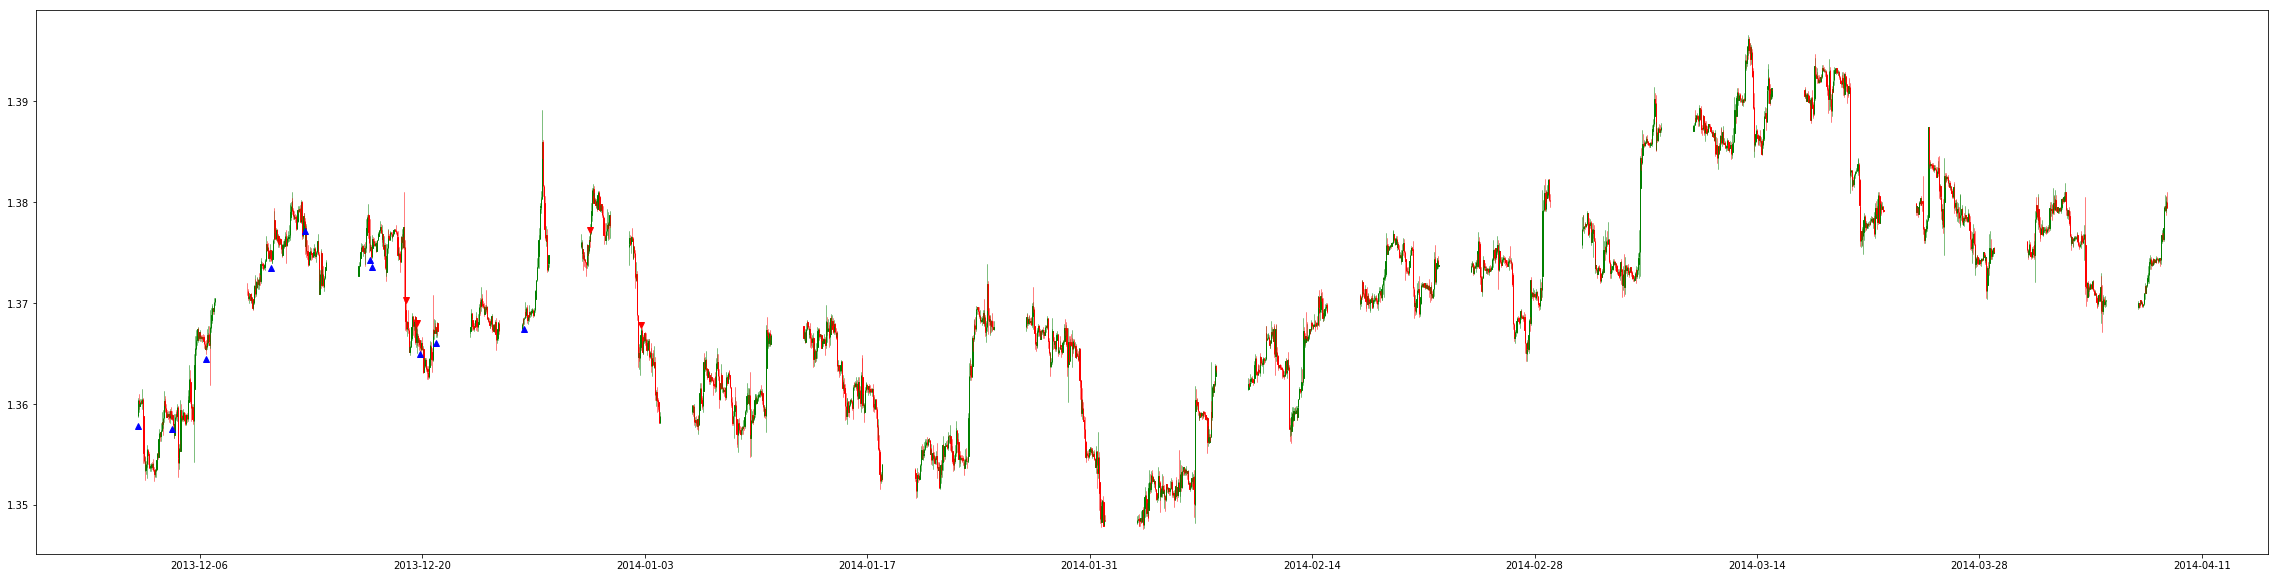

[ { 'Entry Price': 1.3588100000000001,
    'Entry Time': Timestamp('2013-12-02 03:00:00'),
    'Exit Price': 1.35856,
    'Exit Time': Timestamp('2013-12-04 05:00:00'),
    'Profit': -5.5000000000008349,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': -2.1000000000007546},
  { 'Entry Price': 1.35856,
    'Entry Time': Timestamp('2013-12-04 06:00:00'),
    'Exit Price': 1.3654899999999999,
    'Exit Time': Timestamp('2013-12-06 08:00:00'),
    'Profit': 66.299999999998803,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': 70.600000000000364},
  { 'Entry Price': 1.3654999999999999,
    'Entry Time': Timestamp('2013-12-06 09:00:00'),
    'Exit Price': 1.37453,
    'Exit Time': Timestamp('2013-12-10 11:00:00'),
    'Profit': 87.300000000000935,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': 94.400000000000801},
  { 'Entry Price': 1.3745100000000001,
    'Entry Time': Timestamp('2013-12-10 12:00:00'),
    'Exit Price': 1.3781600000000001,
    'Exit Time': Tim

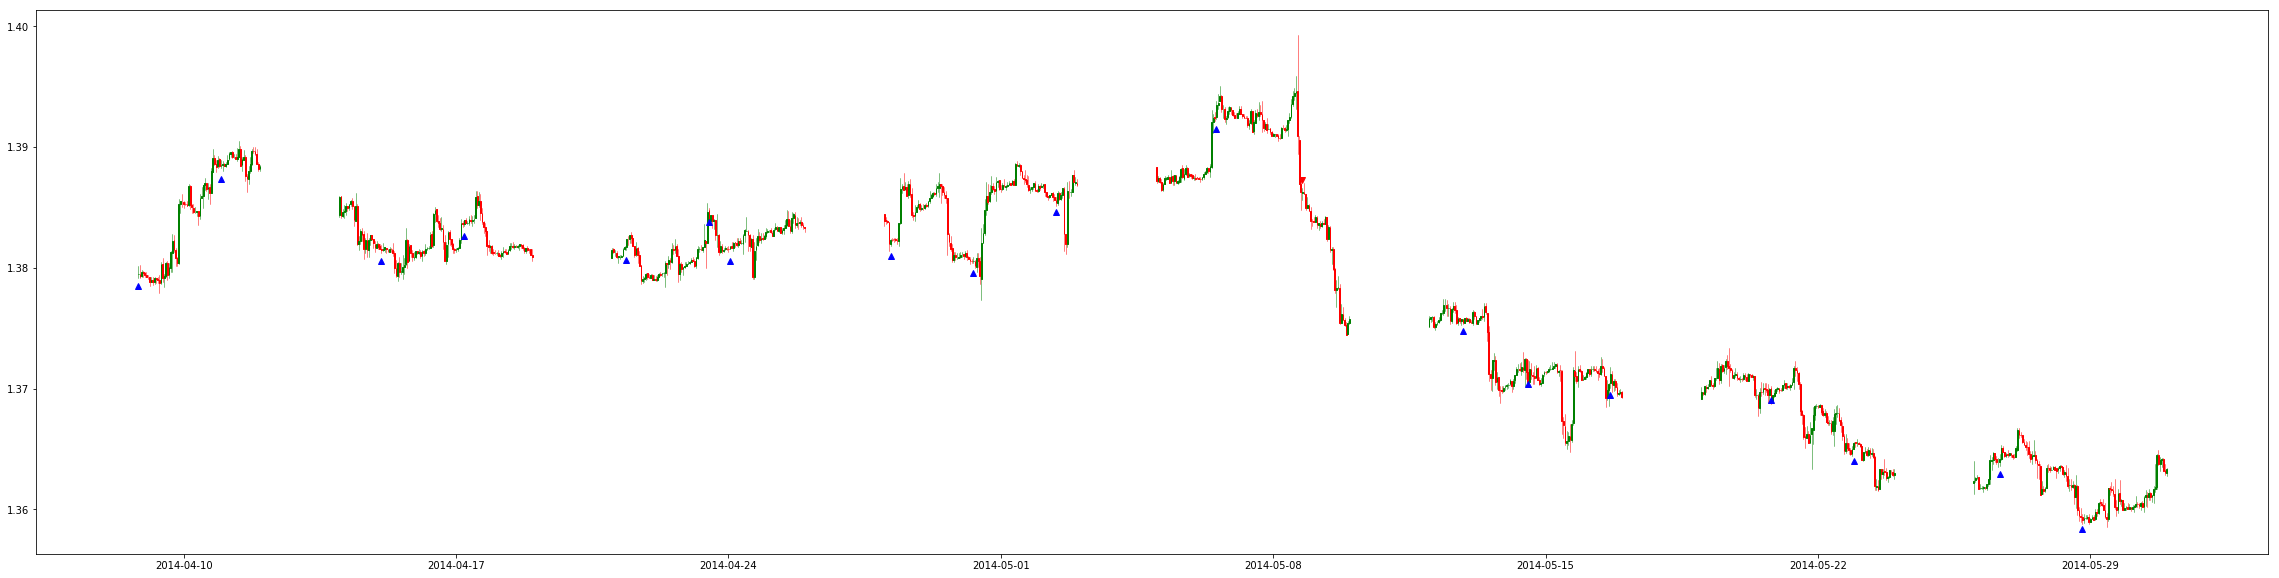

[ { 'Entry Price': 1.3794999999999999,
    'Entry Time': Timestamp('2014-04-08 20:00:00'),
    'Exit Price': 1.3884100000000001,
    'Exit Time': Timestamp('2014-04-10 22:00:00'),
    'Profit': 86.100000000001955,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': 91.400000000001143},
  { 'Entry Price': 1.38839,
    'Entry Time': Timestamp('2014-04-10 23:00:00'),
    'Exit Price': 1.3815600000000001,
    'Exit Time': Timestamp('2014-04-15 01:00:00'),
    'Profit': -71.299999999998917,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': -69.500000000000455},
  { 'Entry Price': 1.3815600000000001,
    'Entry Time': Timestamp('2014-04-15 02:00:00'),
    'Exit Price': 1.3835999999999999,
    'Exit Time': Timestamp('2014-04-17 04:00:00'),
    'Profit': 17.399999999998197,
    'Trade Duration': 50,
    'Type': 'BUY',
    'reward': 18.599999999999397},
  { 'Entry Price': 1.3835999999999999,
    'Entry Time': Timestamp('2014-04-17 05:00:00'),
    'Exit Price': 1.3815299999999999

In [7]:
with U.make_session(8):
    
    act, train, update_target, debug = deepq.build_train(
        make_obs_ph=lambda name: U.BatchInput(env.observation_space.shape, name=name),
        q_func=model,
        num_actions=env.action_space.n,
        optimizer=tf.train.AdamOptimizer(learning_rate=5e-4),
    )

    replay_buffer = ReplayBuffer(50000)
    # Create the schedule for exploration starting from 1 (every action is random) down to
    # 0.02 (98% of actions are selected according to values predicted by the model).
    exploration = LinearSchedule(schedule_timesteps=10000, initial_p=1.0, final_p=0.02)
    # Initialize the parameters and copy them to the target network.
    U.initialize()
    update_target()

    episode_rewards = [0.0]
    obs = env.reset()
    l_mean_episode_reward = []
    for t in itertools.count():
        # Take action and update exploration to the newest value
        action = act(obs[None], update_eps=exploration.value(t))[0]

        new_obs, rew, done, _ = env.step(action)

        # Store transition in the replay buffer.
        replay_buffer.add(obs, action, rew, new_obs, float(done))

        obs = new_obs

        episode_rewards[-1] += rew

        is_solved = np.mean(episode_rewards[-101:-1]) > 500 or t >= 300000
        is_solved = is_solved and len(env.portfolio.journal) > 2
        
        if done:

            journal = pd.DataFrame(env.portfolio.journal)
            profit = journal["Profit"].sum()

            try:
                print("-------------------------------------")
                print("steps                     | {:}".format(t))
                print("episodes                  | {}".format(len(episode_rewards)))
                print("% time spent exploring    | {}".format(int(100 * exploration.value(t))))

                print("--")
                l_mean_episode_reward.append(round(np.mean(episode_rewards[-101:-1]), 1))

                print("mean episode reward       | {:}".format(l_mean_episode_reward[-1]))
                print("Total operations          | {}".format(len(env.portfolio.journal)))
                print("Avg duration trades       | {}".format(round(journal["Trade Duration"].mean(), 2)))
                print("Total profit              | {}".format(round(profit), 1))
                print("Avg profit per trade      | {}".format(round(env.portfolio.average_profit_per_trade, 3)))

                print("--")

                reward_test, profit = run_test(env=env, act=act)
                print("Total profit test:        > {}".format(round(profit, 2)))
                print("Avg profit per trade test > {}".format(round(reward_test, 3)))
                print("-------------------------------------")
            except Exception as e:
                print("Exception: ", e)
                # Update target network periodically.

            obs = env.reset()
            episode_rewards.append(0)



        if is_solved:
            # Show off the result
            env._generate_summary_stats()
            run_test(env, act, final_test=True)
            break

        else:
            # Minimize the error in Bellman's equation on a batch sampled from replay buffer.
            if t > 500:
                obses_t, actions, rewards, obses_tp1, dones = replay_buffer.sample(32)
                train(obses_t, actions, rewards, obses_tp1, dones, np.ones_like(rewards))
            if t % 500 == 0:
                update_target()


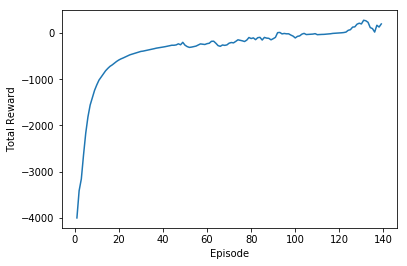

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(l_mean_episode_reward)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

### It converges!
Time to implement your own strategy :) 

And remember, be careful of overfitting.
